# Machine Learning Program Assignment 1

### Name: Cheng Ke
### ID: 518021910095

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
import seaborn as sns
from time import *

## 1. Load training data

In [478]:
data = pd.read_csv("archive/train.csv")

In [479]:
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [480]:
data.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [481]:
data.shape

(2000, 21)

In [482]:
data.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

In [483]:
pd.isnull(data).sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [484]:
data.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


### Is the dataset balanced or imbalanced? 

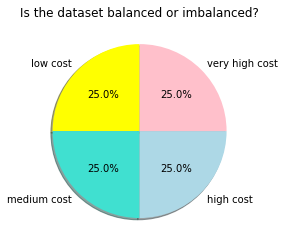

In [485]:
labels = ["low cost", "medium cost", "high cost", "very high cost"]
values = data['price_range'].value_counts().values
colors = ['yellow','turquoise','lightblue', 'pink']
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.set_title('Is the dataset balanced or imbalanced?')
plt.show()

#### We can see from the figure that our dataset is very balanced, the four classes are equal in number

### The correlation between features and target variable by plotting heatmap

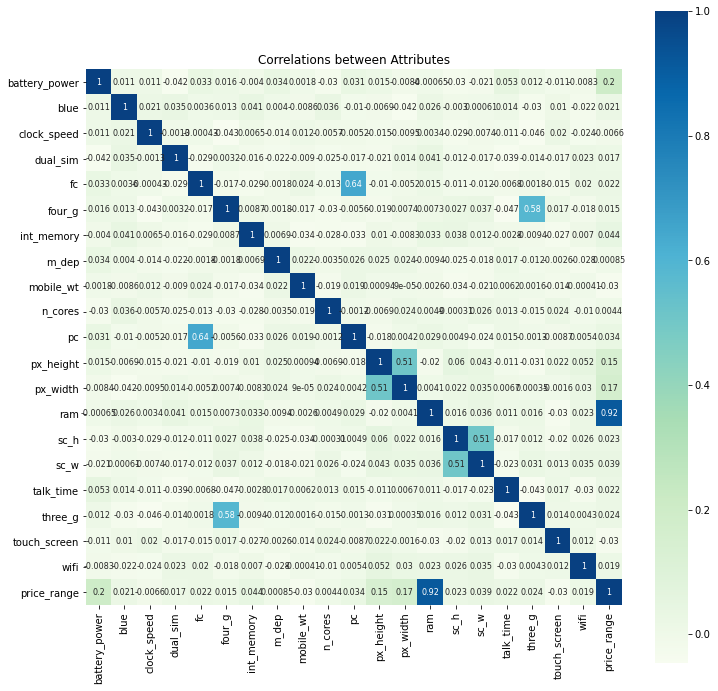

In [486]:
fig = plt.subplots (figsize = (12, 12))
sns.heatmap(data.corr (), square = True, cbar = True, annot = True, cmap="GnBu", annot_kws = {'size': 8})
plt.title('Correlations between Attributes')
plt.show ()

## 2. Data Preprocessing

#### Convert labels into to two classes: low (0, 1) and high (2, 3)

In [487]:
data["price_classification"] = np.where(data["price_range"] <= 1, 0, 1)
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,price_classification
0,842,0,2.2,0,1,0,7,0.6,188,2,...,756,2549,9,7,19,0,0,1,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,1988,2631,17,3,7,1,1,0,2,1
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1716,2603,11,2,9,1,1,0,2,1
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1786,2769,16,8,11,1,0,0,2,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1212,1411,8,2,15,1,1,0,1,0


#### Split the original ‘train.csv’ into ‘train.csv’, ‘valid.csv’ and ‘test.csv’ with the ratio of 0.8 : 0.1 : 0.1

In [488]:
x = data
y = data["price_range"]
train_data, tmp_x, train_y, tmp_y = train_test_split(x, y, test_size = 0.2, random_state = None, stratify = y)
test_data, valid_data, test_y, valid_y = train_test_split(tmp_x, tmp_y, test_size = 0.5, random_state = 101, stratify = tmp_y)

#### Test whether the split works correctly

In [489]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(1600, 22)
(200, 22)
(200, 22)


#### Write the data back to the csv file

In [490]:
train_data.to_csv("train.csv")
test_data.to_csv("test.csv")
valid_data.to_csv("valid.csv")

## 3. Model Implementation

### 3.1 The Sigmoid function

In [491]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### 3.2 Logistic Regression

In [492]:
class LogisticRegression():
    def __init__(self, learning_rate=.1, n_iterations=4000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def initialize_weights(self, n_features):
        limit = np.sqrt(1 / n_features)
        w = np.random.uniform(-limit, limit, (n_features, 1))
        b = 0

        # Insert 0 as w_0
        self.w = np.insert(w, 0, b, axis=0)

    def cost_function(self, data, labels):
        num_examples = data.shape[0]
        num_params = data.shape[1]
        sumOfErrors = 0
        for i in range(num_examples):
            xi = data[i]
            hi = self.hypothesis(xi, self.w)
            if labels[i] == 1:
                error = labels[i] * np.log(hi[0])
            elif labels[i] == 0:
                error = (1 - labels[i]) * np.log(1 - hi[0])
            sumOfErrors += error
        return -1 / num_examples * sumOfErrors

    @staticmethod
    def hypothesis(data, theta):
        z = 0
        num_params = theta.shape[0]
        for i in range(num_params):
            z += data[i] * theta[i]
        return sigmoid(z)

    def fit(self, X, y, valid_X, valid_y):
        # Do data normalization
        self.scaler = preprocessing.StandardScaler().fit(X)
        normal_X = self.scaler.transform(X)

        m_samples, n_features = normal_X.shape
        self.initialize_weights(n_features)

        # Insert 1 as x_0
        normal_X = np.insert(normal_X, 0, 1, axis=1)

        y = np.reshape(y, (m_samples, 1))
        cost_history = []
        correctness = []
        for i in range(self.n_iterations):
            h_x = normal_X.dot(self.w)
            y_pred = sigmoid(h_x)
            w_grad = normal_X.T.dot(y_pred - y)
            self.w = self.w - self.learning_rate * w_grad
            if i % 100 == 0:
                cost = self.cost_function(normal_X, y)
                accuracy = self.test(valid_X, valid_y)
                if len(correctness) > 0 and accuracy - correctness[len(correctness) - 1] > 0.0001:
                    self.n_iterations += 50
                if len(cost_history) > 0 and cost > cost_history[len(cost_history) - 1]:
                    self.learning_rate /= 2
                cost_history.append(cost)
                correctness.append(accuracy)
        return self.w, cost_history, correctness

    def predict(self, X):
        # Do data normalization
        normal_X = self.scaler.transform(X)
        # Insert 1 as x_0
        normal_X = np.insert(normal_X, 0, 1, axis=1)

        h_x = normal_X.dot(self.w)
        y_pred = np.round(sigmoid(h_x))
        return y_pred.astype(int)

    def test(self, X, y):
        y_pred = self.predict(X)
        right_count = 0
        m_samples = X.shape[0]
        for i in range(m_samples):
            if y_pred[i] == y[i]:
                right_count += 1
        return right_count / m_samples 

### 3.3 Naive Bayes

In [493]:
class NaiveBayes():
    def __init__(self, continuous, uncontinuous):
        # Record continuous attributes and uncontinuous attributes
        self.continuous = continuous
        self.uncontinuous = uncontinuous

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        self.parameters = {}
        for i, c in enumerate(self.classes):

            # Calculate prior probability of every class
            prior = y.values[np.where(self.y == c)].shape[0] / self.y.shape[0]

            # Calculate likelihood of every continuous attribute
            likelihood_con = {}
            for item in self.continuous:
                X_index_c_con = self.X[item].values[np.where(self.y == c)]
                X_index_c_con_mean = np.mean(X_index_c_con)
                X_index_c_con_var = np.var(X_index_c_con)
                likelihood_con[item] = {"mean": X_index_c_con_mean, "var": X_index_c_con_var}

            # Calculate likelihood of every uncontinuous attribute
            likelihood_uncon = {}
            for item in self.uncontinuous:
                X_index_c_uncon = self.X[item].values[np.where(self.y == c)]
                classes = np.unique(X_index_c_uncon)
                likelihood = {}
                for class_item in classes:
                    likelihood[class_item] = X_index_c_uncon[np.where(X_index_c_uncon == class_item)].shape[0] / X_index_c_uncon.shape[0]
                likelihood_uncon[item] = {"likelihoods": likelihood}

            self.parameters[c] = {"prior": prior, "likelihood_con": likelihood_con, "likelihood_uncon": likelihood_uncon}    
        return self.parameters

    def predict(self, X):
        # Calculate post probability of every class : P(C_i | x_1 x_2 ... x_n) = P(C_i)P(x_1 | C_i)P(x_2 | C_i)...P(x_n | C_i)
        output = []
        m_samples = X.shape[0]

        # For every sample
        for i in range(m_samples):
            max = float('-inf')
            chosen = 0
            for c in self.classes:
                prior = self.parameters[c]["prior"]
                likelihood_log = 0

                # For every uncontinuous attribute
                for a in self.uncontinuous:
                    x = X[a][i : i + 1].values
                    probability = self.parameters[c]["likelihood_uncon"][a]["likelihoods"][x[0]]
                    likelihood_log += np.log(probability)

                # For every continuous attribute
                for a in self.continuous:
                    mean = self.parameters[c]["likelihood_con"][a]["mean"]
                    var = self.parameters[c]["likelihood_con"][a]["var"]
                    x = X[a][i : i + 1].values
                    probability = self.gaussian_probability(mean, var, x[0])
                    likelihood_log += np.log(probability)

                post_log = np.log(prior) + likelihood_log
                if post_log > max:
                    max = post_log
                    chosen = c
            output.append(chosen)
        return output

    # For continuous variables I assume they are subject to Gaussian Distribution 
    def gaussian_probability(self, mean, var, x):
        eps = 1e-4
        numerator = np.exp(-(x - mean) ** 2 / (2 * var + eps))
        denominator = np.sqrt(2 * np.pi * var + eps)
        result = numerator / denominator
        return result

    def test(self, X, y):
        output = self.predict(X)
        right_count = 0
        m_samples = X.shape[0]
        for i in range(m_samples):
            if output[i] == y.values[i]:
                right_count += 1
        return right_count / m_samples 


## 4. Train models

### 4.1 Decide which fields we want to process

In [494]:
output_param_name = 'price_classification'
price_range = 'price_range'

### 4.2 Split training set and test set into input and output

In [495]:
x_train = train_data.drop(output_param_name,axis=1,inplace=False).drop(price_range,axis=1,inplace=False)
y_train = train_data[output_param_name]
x_test = test_data.drop(output_param_name,axis=1,inplace=False).drop(price_range,axis=1,inplace=False)
y_test = test_data[output_param_name]
x_valid = valid_data.drop(output_param_name,axis=1,inplace=False).drop(price_range,axis=1,inplace=False)
y_valid = valid_data[output_param_name]

#### Check whether the split works correctly

In [496]:
x_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
987,1688,0,2.5,0,0,1,21,0.2,170,7,0,650,864,3984,17,14,8,1,1,1
1641,1109,1,2.8,1,6,0,57,0.9,151,1,12,124,833,2785,15,10,16,1,0,0
1788,1424,0,0.5,1,16,1,23,0.6,80,4,18,1399,1663,1053,14,11,16,1,1,1
1852,648,1,1.8,0,1,1,60,0.1,195,4,4,931,1811,819,10,3,4,1,0,0
1464,776,1,1.7,0,0,1,20,1.0,146,4,9,991,1803,685,15,11,7,1,1,1


In [497]:
y_train.head()

987     1
1641    1
1788    0
1852    0
1464    0
Name: price_classification, dtype: int32

In [498]:
x_test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1800,1358,0,1.7,0,0,0,60,0.6,147,3,1,889,1635,440,14,10,13,1,0,0
1280,1426,0,1.6,0,4,1,12,0.7,174,5,16,1573,1694,1277,14,9,5,1,0,0
745,894,0,2.1,1,16,0,16,0.7,168,8,20,286,1300,3377,5,1,6,1,1,1
1480,603,0,1.5,0,8,0,12,0.7,114,6,20,1003,1284,1543,7,5,19,1,1,0
1382,1420,0,2.8,1,1,0,50,0.1,100,8,8,194,1393,763,17,1,17,0,1,1


In [499]:
y_test.head()

1800    0
1280    0
745     1
1480    0
1382    0
Name: price_classification, dtype: int32

### 4.3 Train Logistic Regression Model

In [500]:
logistic_regression = LogisticRegression()
train_start_time_1 = time()
(theta, cost_history, correctness) = logistic_regression.fit(x_train.values, y_train.values, x_valid.values, y_valid.values)
train_end_time_1 = time()

#### 4.3.1 Print model parameters

In [501]:
theta_table = pd.DataFrame({'Model Parameters': theta.flatten()})
print(theta_table)

    Model Parameters
0           0.243693
1          25.692602
2          -0.469499
3          -1.196329
4          -0.603118
5          -0.914762
6          -0.571488
7           1.161199
8          -0.072623
9          -3.255882
10          0.696925
11          0.520674
12         14.106375
13         15.063691
14         98.155148
15         -0.504032
16          0.789854
17          1.286025
18          0.423060
19         -0.709940
20         -1.106916


#### 4.3.2 Plot gradient descent progress

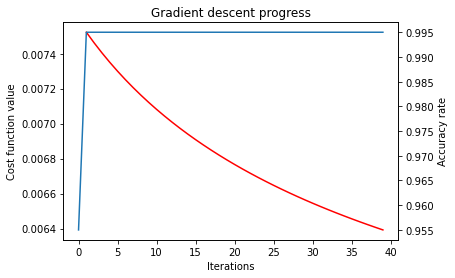

In [502]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(range(len(cost_history)), cost_history, color = "red", label = "cost")
ax1.set_ylabel("Cost function value")
ax1.set_xlabel("Iterations")
ax1.set_title("Gradient descent progress")
ax2 = ax1.twinx()
ax2.plot(range(len(cost_history)), correctness, label = "accuracy rate")
ax2.set_ylabel("Accuracy rate")
plt.show()

### 4.4 Train Naive Bayes Model

#### Continuous attributes and uncontinuous attributes

In [503]:
continuous = [
    'battery_power',
    'clock_speed',
    'fc',
    'int_memory',
    'm_dep',
    'mobile_wt',
    'pc',
    'px_height',
    'px_width',
    'ram',
    'sc_h',
    'sc_w',
    'talk_time'
]
uncontinuous = [
    'blue',
    'dual_sim',
    'four_g',
    'n_cores',
    'three_g',
    'touch_screen',
    'wifi'
]

In [504]:
naive_bayes = NaiveBayes(continuous, uncontinuous)
train_start_time_2 = time()
params = naive_bayes.fit(x_train, y_train)
train_end_time_2 = time()

#### Print parameters

In [505]:
print("Parameters of Naive Bayes Model: ", params)

Parameters of Naive Bayes Model:  {0: {'prior': 0.5, 'likelihood_con': {'battery_power': {'mean': 1172.3425, 'var': 178726.19019375}, 'clock_speed': {'mean': 1.5348750000000002, 'var': 0.6913462343750001}, 'fc': {'mean': 4.12125, 'var': 18.759048437499995}, 'int_memory': {'mean': 31.2475, 'var': 321.48374375}, 'm_dep': {'mean': 0.502, 'var': 0.08197099999999999}, 'mobile_wt': {'mean': 141.0225, 'var': 1307.55199375}, 'pc': {'mean': 9.7775, 'var': 38.540493749999996}, 'px_height': {'mean': 608.41875, 'var': 170334.3658984375}, 'px_width': {'mean': 1200.21875, 'var': 185918.1358984375}, 'ram': {'mean': 1227.91, 'var': 377684.99189999996}, 'sc_h': {'mean': 12.3475, 'var': 17.81424375}, 'sc_w': {'mean': 5.59375, 'var': 18.0537109375}, 'talk_time': {'mean': 11.01125, 'var': 29.9511234375}}, 'likelihood_uncon': {'blue': {'likelihoods': {0: 0.52, 1: 0.48}}, 'dual_sim': {'likelihoods': {0: 0.49625, 1: 0.50375}}, 'four_g': {'likelihoods': {0: 0.47375, 1: 0.52625}}, 'n_cores': {'likelihoods': {1

### 4.5 Train SVM Model

In [506]:
clf = svm.SVC()
train_start_time_3 = time()
clf.fit(x_train.values, y_train.values)
train_end_time_3 = time()

## 5. Test models

### 5.1 Test Logistic Regression Model

In [507]:
accuracy_result_train_1 = logistic_regression.test(x_train.values, y_train.values)
test_start_time_1 = time()
accuracy_result_1 = logistic_regression.test(x_test.values, y_test.values)
test_end_time_1 = time()
print('Accuracy rate of Logistic Regression Model on training data: {:.2f}' .format(accuracy_result_train_1))
print('Accuracy rate of Logistic Regression Model on test data: {:.2f}' .format(accuracy_result_1))

Accuracy rate of Logistic Regression Model on training data: 1.00
Accuracy rate of Logistic Regression Model on test data: 0.96


### 5.2 Test Naive Bayes Model

In [508]:
accuracy_result_train_2 = naive_bayes.test(x_train, y_train)
test_start_time_2 = time()
accuracy_result_2 = naive_bayes.test(x_test, y_test)
test_end_time_2 = time()
print('Accuracy rate of Naive Bayes Model on training data: {:.2f}' .format(accuracy_result_train_2))
print('Accuracy rate of Naive Bayes Model on test data: {:.2f}' .format(accuracy_result_2))

Accuracy rate of Naive Bayes Model on training data: 0.94
Accuracy rate of Naive Bayes Model on test data: 0.91


### 5.3 Test SVM Model

In [509]:
accuracy_result_train_3 = clf.score(x_train.values, y_train.values)
test_start_time_3 = time()
accuracy_result_3 = clf.score(x_test.values, y_test.values)
test_end_time_3 = time()
print('Accuracy rate of SVM Model on training data: {:.2f}' .format(accuracy_result_train_3))
print('Accuracy rate of SVM Model on test data: {:.2f}' .format(accuracy_result_3))

Accuracy rate of SVM Model on training data: 0.98
Accuracy rate of SVM Model on test data: 0.96


## 6. Empirical Study

### 6.1 Compare the three methods with respect to the classification accuracy on the training set and test set

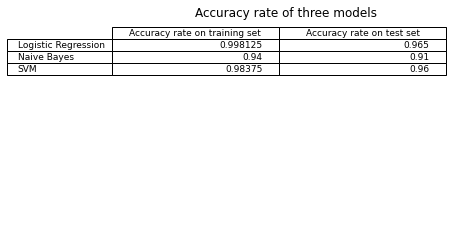

In [510]:
models = ["Logistic Regression","Naive Bayes","SVM"]
table_vals = [
    [accuracy_result_train_1, accuracy_result_1],
    [accuracy_result_train_2, accuracy_result_2],
    [accuracy_result_train_3, accuracy_result_3]
    ]
plt.table(cellText = table_vals, rowLabels = models, colLabels = ["Accuracy rate on training set", "Accuracy rate on test set"], loc = "best")
plt.axis("off")
plt.title("Accuracy rate of three models")
plt.show()

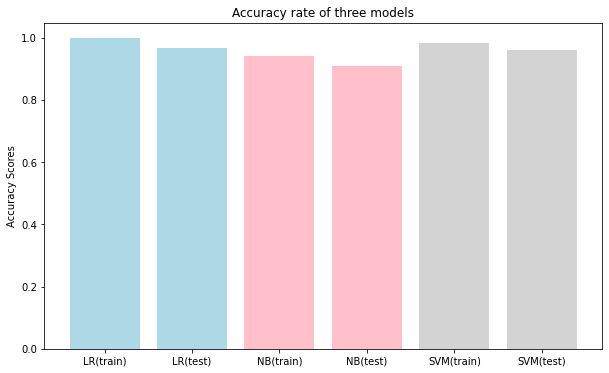

In [511]:
models = [
    'LR(train)', 
    'LR(test)',
    'NB(train)',
    'NB(test)',
    'SVM(train)',
    'SVM(test)'
    ]
acc_scores = [
    accuracy_result_train_1, 
    accuracy_result_1, 
    accuracy_result_train_2,
    accuracy_result_2, 
    accuracy_result_train_3,
    accuracy_result_3
    ]
plt.figure(figsize=(10,6))
plt.bar(models, acc_scores, color=['lightblue', 'lightblue', 'pink', 'pink', 'lightgrey', 'lightgrey', 'cyan'])
plt.ylabel("Accuracy Scores")
plt.title("Accuracy rate of three models")
plt.show()

#### We can see from the figure that each model performs slightly better on the training set than on the test set. Logistic Regression and SVM can achive nearly 100% accuracy rate, and Naive Bayes can achive the accuracy rate of about 95%

### 6.2 Compare time consuming

In [512]:
train_time_1 = train_end_time_1 - train_start_time_1
train_time_2 = train_end_time_2 - train_start_time_2
train_time_3 = train_end_time_3 - train_start_time_3
test_time_1 = test_end_time_1 - test_start_time_1
test_time_2 = test_end_time_2 - test_start_time_2
test_time_3 = test_end_time_3 - test_start_time_3
models = [
    "LR(train)",
    "LR(predict)",
    "NB(train)",
    "NB(predict)",
    "SVM(train)",
    "SVM(predict)"
    ]

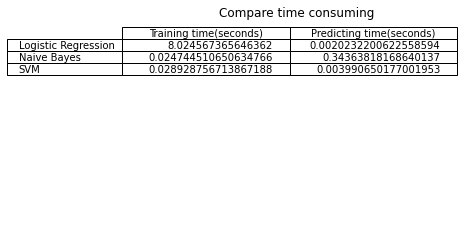

In [513]:
table_vals = [
    [train_time_1, test_time_1],
    [train_time_2, test_time_2],
    [train_time_3, test_time_3]
    ]
plt.table(cellText = table_vals, rowLabels = ["Logistic Regression", "Naive Bayes", "SVM"], colLabels = ["Training time(seconds)", "Predicting time(seconds)"], loc = "best")
plt.axis("off")
plt.title("Compare time consuming")
plt.show()

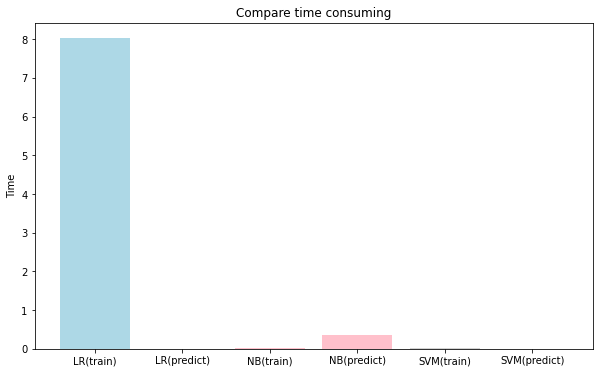

In [514]:
train_time = [
    train_time_1,
    test_time_1, 
    train_time_2,
    test_time_2, 
    train_time_3,
    test_time_3
    ]
plt.figure(figsize=(10,6))
plt.bar(models, train_time, color=['lightblue', 'lightblue', 'pink', 'pink', 'lightgrey', 'lightgrey', 'cyan'])
plt.ylabel("Time")
plt.title("Compare time consuming")
plt.show()

#### We can see from the figure that training Logistic Regression costs dramatically more time than training other two models, while using Naive Bayes to predict costs more time than using other two models.

### 6.3 Conclusion

#### From the analysis above we can see that Logistic Regression and SVM achive better accuracy rate than Naive Bayes. 
#### In terms of time consuming, Logistic Regression takes dramatically more time to train while Naive Bayes takes more time to predict.
#### Thus we can conclude that:
#### For Logistic Regression, its pro is that it can achieve nearly 100 percent accuracy rate, but it requires several seconds to train and it has difficulty in handling multi-class classification and non-linear classification.
#### For Naive Bayes, its training time and predicting are ideal and it can handle multi-class classification without any problem, but its predicting accuracy rate is low compared to other two models and it is sensitive to the continuity of input data.
#### For SVM, it achieves good performance in both predicting accuracy and time consuming. Furthermore, from the class I learned that SVM is a very robust model because its parameters only depend on support vectors. But it also has difficulty in handling multi-class classification.